In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ase.io.gaussian import read_gaussian_out
import ase.units


import matplotlib
from rmgpy.data.thermo import ThermoDatabase
from rmgpy.species import Species

In [2]:
# NIST reference data
# https://webbook.nist.gov/cgi/cbook.cgi?ID=C7732185&Units=SI&Mask=1&Type=JANAFG&Table=on#JANAFG

In [3]:
nist_csv = '/home/moon/hw8/ads_thermo_presentation/h2o_nist_data.csv'
nist_df = pd.read_csv(nist_csv, header=0, skiprows=2, names=['Temperature', 'Cp', 'S', 'S2', 'H'])

In [4]:
T = nist_df.Temperature.values
# T = [298.15]

Mass of H2O

$\frac{18 grams}{mol}\cdot \frac{1 mol}{6.02\times 10^{23} molecules} \cdot \frac{1 kg}{1000 grams}$

In [5]:
# Load Constants

kb = ase.units._k
MW_H2O = 18.01528
N_av = ase.units._Nav
h = ase.units._hplanck
mass_H2O = MW_H2O / N_av / 1000.0
volume = 1.0  # m^3
R = 8.31446261815324  # J/mol K

## Translation Partition Function

$$q_{trans} = \left(\frac{2 \pi \sum_{atoms, i} m_i k T}{h^2} \right)^{\frac{3}{2}}V$$

$h=6.62607004\times 10^{-34} \quad $ Planck's constant in $\frac{m^2 \cdot kg}{s}\quad$

$k=1.38064852\times 10^{-23} \quad $ Boltmann's constant in $\frac{m^2 \cdot kg}{s^2 \cdot K}\quad$

$m_i \quad $ Mass of atom $i$ in $kg$

$T \quad$ Temperature in $K$

Assume Ideal Gas
$PV=nRT$

$V=\frac{nRT}{P}$

$$q_{trans} = \left(\frac{2 \pi \sum_{atoms, i} m_i k T}{h^2} \right)^{\frac{3}{2}} \frac{NRT}{P}$$

$R = 8.314462$ gas constant in $\frac{J}{mol\cdot K}$

$n\quad$ number of mols

$P\quad$ pressure in Pascals


In [6]:
n = 1.0 / N_av  # convert from one molecule to units of mols
P = 101325  # 1 atm for comparison with Guassian results
V = n * R * T / P

q_trans = np.float_power(2.0 * np.pi * mass_H2O * kb * T / np.float_power(h, 2.0), 1.5) * V
# print(q_trans)

## Rotational Partition Function

Linear Molecules:
$$q_{rot} = \frac{T}{\sigma \Theta_r} \quad$$

Nonlinear Molecules:
$$q_{rot} = \frac{\sqrt{\pi}}{\sigma} \left( \frac{T^3}{\Theta_A\Theta_B\Theta_C}\right)^{\frac{1}{2}} \quad$$


$\sigma\quad$ Rotational Symmetry Number

$\Theta_r=\frac{h^2}{8\pi^2Ik}\quad$ Rotational Temperature in $K$

$h=6.62607004\times 10^{-34} \quad $ Planck's constant in $\frac{m^2 \cdot kg}{s}\quad$

$k=1.38064852\times 10^{-23} \quad $ Boltmann's constant in $\frac{m^2 \cdot kg}{s^2 \cdot K}\quad$

$T \quad$ Temperature in $K$

$I\quad$ Moment of Inertia in $kg \cdot m^2$

In [7]:
# Get the inertia along the principal axis of rotation
with open('h2o.log', 'r') as f:
    atoms = read_gaussian_out(f)

# Linear
# # The [-1] is to pick the primary axis of rotation and then later include the symmetry number
# I = np.linalg.norm(atoms.get_moments_of_inertia()[-1])

# # convert from amu*Angstroms^2 to kg*m^2
# I /= (ase.units.kg * ase.units.m * ase.units.m)

# rotational_temperature = np.float_power(h, 2.0) / (8.0 * np.pi * np.pi * I * kb)
# rotational_symmetry = 2.0  # 2 identical axes of rotation for linear CO2

# q_rot = T / (rotational_symmetry * rotational_temperature)


# Nonlinear
I = atoms.get_moments_of_inertia()

# # convert from amu*Angstroms^2 to kg*m^2
I /= (ase.units.kg * ase.units.m * ase.units.m)

rotational_temperatures = np.float_power(h, 2.0) / (8.0 * np.pi * np.pi * I * kb)
rotational_symmetry = 1.0  # 2 for H2O?

q_rot = np.sqrt(np.pi) / rotational_symmetry * np.sqrt(np.float_power(T, 3.0) / (np.prod(rotational_temperatures)))
# print(q_rot)

## Vibrational Partition Function

https://en.wikipedia.org/wiki/Vibrational_partition_function
$$q_{vib} = e^{-\frac{\frac{1}{2}\sum_i{h\nu_i}}{kT}} \prod_{i=1}^{l} \frac{1}{1-e^{-\Theta_{v,i}/T}}$$

$T \quad$ Temperature in $K$

$\Theta_v=\frac{h \nu}{k}\quad$ Vibrational Temperature in $K$

$h=6.62607004\times 10^{-34} \quad $ Planck's constant in $\frac{m^2 \cdot kg}{s}\quad$

$k=1.38064852\times 10^{-23} \quad $ Boltmann's constant in $\frac{m^2 \cdot kg}{s^2 \cdot K}\quad$

$\nu \quad$ Vibrational Frequency in $\frac{1}{s}$

$l \quad$ Number of Vibrational Modes



Note that frequencies in Gaussian are in units of reciprocal cm, need converting to per second using the speed of light:

$c = \lambda \nu$

$\lambda \quad$ Wavelength in $m$

$c = 299792458 \quad$ Speed of Light in $\frac{m}{s}$

$\nu = \frac{c}{\lambda}$

In [8]:
vib_freqs_per_cm = np.array([1628.95, 3872.18, 3973.96])
freq_correction = 0.982
vib_freqs_per_cm *= freq_correction

c = 29979245800  # speed of light in cm/s
vib_freqs = c * vib_freqs_per_cm  # frequencies should be on the order of 10^12

vib_temps = h * vib_freqs / kb  # matches Gaussian log

E_zp = np.exp(-0.5 * h * np.sum(vib_freqs) / (kb * T))

# q_vib = E_zp
q_vib = np.ones(len(T))
for i in range(0, len(vib_temps)):
    q_vib = np.multiply(q_vib, 1.0 / (1.0 - np.exp(-vib_temps[i]/T)))
# print(q_vib)

## Electronic Partition Function

$$q_{elec} = \omega_1 e^{-\varepsilon_1/kT} + \omega_2 e^{-\varepsilon_2/kT} + ...$$

Set the ground state to zero: $\varepsilon_1=0$

Assume there is a large gap between the ground state and higher electronic states:

$\varepsilon_2/kT \rightarrow \infty$

$e^{-\varepsilon_2/kT} + ... \approx 0$

$$q_{elec} = \omega_1$$
This is the spin multiplicity of the molecule

In [9]:
q_elec = 1
# print(q_elec)


## Total Partition Function

In [10]:
Q = np.multiply(np.multiply(np.multiply(q_trans, q_rot), q_vib), q_elec)
# print(Q)

## Entropy $S$

In [11]:
N = N_av
S_elec = np.log(1.0)
S_trans = np.log(np.float_power(2.0 * np.pi * mass_H2O * kb * T / (h * h), 1.5) * V / N)
S_vib = np.zeros(len(T))
for theta in vib_temps:
    S_vib += np.multiply(theta / T, (np.divide(np.exp(-theta / T), 1.0 - np.exp(-theta / T)))) - np.log(1.0 - np.exp(-theta / T))
S_rot = np.log(np.sqrt(np.pi) / rotational_symmetry * np.sqrt(np.float_power(T, 3.0)/np.prod(rotational_temperatures)))
S = N * kb *(4 + S_trans + S_rot + S_elec + S_vib)

## Heat Capacity $C_p$

In [12]:
Cv_Nk = 3.0
for theta in vib_temps:
    Cv_Nk += np.multiply(np.float_power(theta / T, 2.0), np.divide(np.exp(-theta / T), np.float_power(1.0 - np.exp(-theta / T), 2.0))) 

# for theta in vib_temps:
#     Cv_Nk += np.float_power(theta / 2.0 * T, 2.0) / (np.float_power(np.sinh(theta / (2.0 * T)), 2.0))
Cv = N * kb * Cv_Nk
Cp = Cv + R

## Enthalpy $H$

$H = U + PV$

In [13]:
U_NkT = 3.0
for theta in vib_temps:
    U_NkT += theta / (2.0 * T) + (theta / T) * np.divide(np.exp(-theta / T), (1.0 - np.exp(-theta / T)))

U = np.multiply(U_NkT, N * kb * T)
H = (U + P * V * N) / 1000.0

## Arkane results

In [14]:
# Specify Input Parameters
species_smiles = "O"
ark_thermo_dir = "/home/moon/hw8/ads_thermo_presentation/H2O_arkane/RMG_libraries/"
ref_lib = 'GRI-Mech3.0'

In [15]:
# Load the Arkane thermo
ark_thermo_database = ThermoDatabase()
ark_thermo_database.load_libraries(
    ark_thermo_dir,
)

In [16]:
ark_species = Species(smiles=species_smiles)
ark_species.thermo = ark_thermo_database.get_thermo_data(ark_species)

In [17]:
# Calculate H, S, and Cp
T = np.linspace(300.0, 3000.0, 100)
H_ark = np.zeros(len(T))
S_ark = np.zeros(len(T))
Cp_ark = np.zeros(len(T))

T_ref = 273.0
H0_ark = ark_species.get_enthalpy(T_ref)
for i, T_ in enumerate(T):
    H_ark[i] = ark_species.get_enthalpy(T_) - H0_ark
    S_ark[i] = ark_species.get_entropy(T_)
    Cp_ark[i] = ark_species.get_heat_capacity(T_)

Text(0.5, 1.0, 'Enthalpy vs. Temperature')

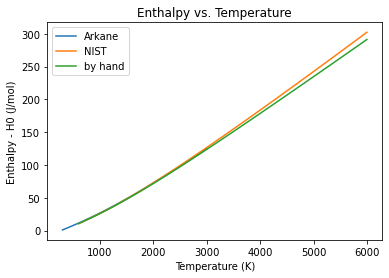

In [18]:
# Plot Enthalpy
# to embed the plot in the Jupyter Notebook because I messed up my settings a while ago
%matplotlib inline
plt.plot(T, H_ark / 1000.0, nist_df.Temperature.values, nist_df.H.values, nist_df.Temperature.values, H - (H[0] - nist_df.H.values[0]))

plt.legend(['Arkane', 'NIST', 'by hand'])
plt.xlabel('Temperature (K)')
plt.ylabel('Enthalpy - H0 (J/mol)')
plt.title('Enthalpy vs. Temperature')

Text(0.5, 1.0, 'Heat Capacity vs. Temperature')

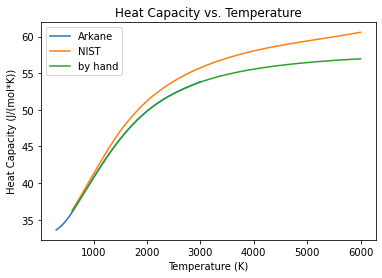

In [19]:
# Plot Heat Capacity
# to embed the plot in the Jupyter Notebook because I messed up my settings a while ago
%matplotlib inline
plt.plot(T, Cp_ark, nist_df.Temperature.values, nist_df.Cp.values, nist_df.Temperature.values, Cp)
plt.legend(['Arkane', 'NIST', 'by hand'])
plt.xlabel('Temperature (K)')
plt.ylabel('Heat Capacity (J/(mol*K))')
plt.title('Heat Capacity vs. Temperature')

Text(0.5, 1.0, 'Entropy vs. Temperature')

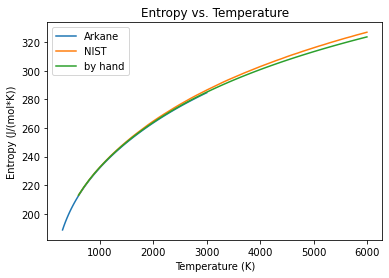

In [20]:
# Plot Entropy
plt.plot(T, S_ark, nist_df.Temperature.values, nist_df.S.values, nist_df.Temperature.values, S - (S[0] - nist_df.S.values[0]))
plt.legend(['Arkane', 'NIST', 'by hand'])
plt.xlabel('Temperature (K)')
plt.ylabel('Entropy (J/(mol*K))')
plt.title('Entropy vs. Temperature')